In [1]:
from astrodendro import Dendrogram, pp_catalog
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import regions
import numpy as np
from astropy import coordinates
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import QTable, Table, Column
import matplotlib.cm as cm
from pyregion.mpl_helper import properties_func_default
from astropy.visualization import simple_norm
from astropy.stats import mad_std
#from regions import DS9Parser
import re
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import warnings
from astropy import visualization
from astropy.stats import mad_std
from astropy.io import ascii
# from astropy.table import Table
import regions
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp

from gaussfit_catalog import gaussfit_catalog
import pandas as pd
from astropy.table import vstack

In [2]:
pwd

'/home/nbudaiev'

In [3]:
cd

/home/nbudaiev


In [4]:
cd /orange/adamginsburg/sgrb2/NB

/orange/adamginsburg/sgrb2/NB


In [5]:
def read_in(path):
    """
    Simplify reading in the files.
    """
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
    data=fh[0].data
    return data, wcs

In [6]:
def basefigure(data):
    """
    Set up basefigure for plotting the data. 
    """
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(projection=wcs_out)
    im = ax.imshow(data, cmap='gray_r', norm=norm1)
    
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([ax.get_position().x1-0.1,
        ax.get_position().y0,
        0.02,
        ax.get_position().height])

    cb = plt.colorbar(mappable=im, cax=cax)
    cb.ax.tick_params(labelsize=tick_fontsize)
    ax.axis([167,1617,210,1618]) # The original images nave a few extra NaN rows and columns.

    
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    radesys = wwM.wcs.radesys
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    ax.axis([0,7719,0,10579])
    return fig, ax

In [7]:
def set_up_regions(path,wX):
    """
    Modifies a CASA-created DS9 region file to a version that works with Astrodendro package.
    Adds 'source_X' text to each region, where X is a source number based on its RA.
    
    Outputs:
    includeX: original DS9 regions
    regionsX: modified version of DS9 regions that works with Astrodendro
    pixelX: same as regionsX, but with pixel coordinates.
    """
    includeX = regions.Regions.read(path)
    strX = regions.Regions.serialize(includeX, format='ds9')
    start = []
    for m in re.finditer('source=1', strX):
        start += [m.end()]
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        strM = strX[:loc] + ' text={source_' + x +'}' + strX[loc:]
    parser = regions.Regions.parse(strX, format='ds9')
    regionsX = parser.serialize(format='ds9')
    #regions.write_ds9(regionsX, 'regionsX_text.reg')
    pixelX = [region.to_pixel(wX) for region in includeX]
    return includeX, regionsX, pixelX

In [8]:
# TEST = []
# for i in range(len(cat['_idx'])):
#     if cat['_idx'][i] in cat_final['_idx']:
#         TEST+=[1]
#     else:
#         TEST+=[0]

In [9]:
def set_up_catalog(d,wX,includeX,central=False):
    """
    Creates a dendrogram catalog.
    Removes sources that are not inside includeX regions.
    Removes sources that are above level 5 in the dendrogram (removes some unwated 
    detections from extended structures).
    """
    cat = pp_catalog(d.leaves,metadata={'data_unit':u.Jy,'wcs': wX},verbose=False)
    print('Total detections: '+str(len(d.leaves)))
    purgeX = []
    for i in range(len(d)):
        if d[i].level > 5: 
            purgeX += [d[i].idx]
    coordsX = coordinates.SkyCoord(cat['x_cen'], cat['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    containsX = np.zeros(len(cat),dtype=bool)
    for X in includeX:
        containsX[X.contains(coordsX, wX)] = 1
    print('Total detections inside input regions: '+str(np.sum(containsX)))
    cat_cut = cat[containsX]
    
    if central:
        print('Central region. No trimming performed')
        cat_coords = coordinates.SkyCoord(cat_cut['x_cen'], cat_cut['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_cut, cat_cut['_idx']
    else:
        cat_final= cat_cut[:0].copy()
        for i in range(len(cat_cut)):    
            if cat_cut['_idx'][i] not in purgeX:
                cat_final.add_row(cat_cut[i])
        print('Total detections after triming above level 5: '+str(len(cat_final)))
        cat_coords = coordinates.SkyCoord(cat_final['x_cen'], cat_final['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
        return cat_coords, cat_final, cat_final['_idx']

In [10]:
def regions_gaussfit(cat_final):
    """
    Creates a DS9 region file from the catalog. The centers and sizes of each region
    are based on ['x_cen'], ['y_cen'], and ['radius'] columns in the catalog.
    """
    centerX = SkyCoord(cat_final['x_cen'], cat_final['y_cen'],unit='deg')
    # There are some problems with displaying these regions in DS9.
    # Use 1st option to display the regions in DS9.
    # Use 2nd option to have proper radii for later use.
    radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
    #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    cat_regionsX = []
    for i in range(len(centerX)):
        cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
    str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX)
    start = []
    for m in re.finditer('\)', str_cat_regionsX):
        start += [m.end()]
    str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
    str2 = '}'
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
    parser = DS9Parser(str_cat_regionsX)
    str_cat_regionsX = parser.shapes.to_regions()
    regions.write_ds9(str_cat_regionsX, "regionsN_text_degrees.reg")
    #return str_cat_regionsX

In [11]:
def makefig(data,catX_pixel,pixelX,xl=0,xu=9999,yl=0,yu=9999,plotsources=True):
    if xu == 9999:
        xu = len(data)
        yu = len(data)
    mad = mad_std(data, ignore_nan=True)
    norm = visualization.simple_norm(data, stretch='linear', min_cut=-3*mad, max_cut=8*mad,)
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8])
    fig.add_axes(ax)
    ax.axis([xl,xu,yl,yu])
    ax.imshow(data, cmap='Greys', norm=norm, origin="lower")

    cm = plt.cm.get_cmap('inferno')
    cm.set_under((0,0,0,0))
    vmin = norm.vmax*0.99
    norm2 = visualization.simple_norm(data, min_cut=vmin, stretch='log', max_percent=100)
    norm2.vmin = vmin
    im2 = ax.imshow(data, cmap='inferno',norm=norm2)
    
    
    if plotsources:
        ax.plot(catX_pixel[0],catX_pixel[1],'X',alpha=1,color='aqua')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            for region in pixelX: 
                region.plot(color='green',alpha=1,fill=False)

2300,2800,400,900 DS

2500,3000,1500,1800 #MN

2600,3000,2400,3000 #N

2400,3000,2400,3000 #M

In [58]:
pathN='NB.sgr_b2.N.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'
pathM='NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'

In [59]:
# New files
#pathN='sgr_b2.N.B3.cont.r0.5.500k0.1mjy.cal2.image.tt0.pbcor.fits'
#pathM='sgr_b2.M.B3.cont.r0.5.500k0.1mjy.cal2.image.tt0.pbcor.fits'

In [60]:
#pathM='NB.sgr_b2.M.B6.cont.pb0.1.r0.5.clean100k2mjy_pcal2.image.tt0.pbcor.fits'
#pathN='NB.sgr_b2.N.B6.cont.pb0.1.r0.5.clean100k2mjy_pcal2.image.tt0.pbcor.fits'

In [61]:
Ncal, wN = read_in(pathN)
Mcal, wM = read_in(pathM)

In [62]:
regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
regionsMc_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_center.reg'
regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_regions.reg'
regionsNc_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_center.reg'

In [63]:
includeM, regionsM, pixelM = set_up_regions(regionsM_path,wM)
includeN, regionsN, pixelN = set_up_regions(regionsN_path,wN)
includeMc, regionsMc, pixelMc = set_up_regions(regionsMc_path,wM)
includeNc, regionsNc, pixelNc = set_up_regions(regionsNc_path,wN)

In [64]:
dN = Dendrogram.compute(Ncal, min_value = 0.00015, min_delta=0.00005, min_npix = 15) # Outside the center
dM = Dendrogram.compute(Mcal, min_value = 0.00015, min_delta=0.0001, min_npix = 15) # Outside the center
dMc = Dendrogram.compute(Mcal, min_value = 0.0001, min_delta=0.0003, min_npix = 10) # Central region
dNc = Dendrogram.compute(Ncal, min_value = 0.0001, min_delta=0.0001, min_npix = 10) # Central region

#dN = Dendrogram.compute(Ncal, min_value = 0.0005, min_delta=0.0002, min_npix = 50) # Outside the center B6
#dM = Dendrogram.compute(Mcal, min_value = 0.0005, min_delta=0.0002, min_npix = 50) # Outside the center B6

In [65]:
cat_coordsM, cat_finalM, IDsM = set_up_catalog(dM,wM,includeM,central=False)

Total detections: 11784
Total detections inside input regions: 149
Total detections after triming above level 5: 138


In [66]:
cat_coordsN, cat_finalN, IDsN = set_up_catalog(dN,wN,includeN,central=False)

Total detections: 11168
Total detections inside input regions: 147
Total detections after triming above level 5: 146


In [67]:
cat_coordsMc, cat_finalMc, IDsMc = set_up_catalog(dMc,wM,includeMc,central=True)

Total detections: 1630
Total detections inside input regions: 42
Central region. No trimming performed


In [68]:
cat_coordsNc, cat_finalNc, IDsNc = set_up_catalog(dNc,wN,includeNc,central=True)

Total detections: 15677
Total detections inside input regions: 85
Central region. No trimming performed


In [69]:
138,146,42,85

(138, 146, 42, 85)

In [70]:
186,152,252,89

(186, 152, 252, 89)

In [71]:
cat_final=vstack([cat_finalM,cat_finalMc,cat_finalN,cat_finalNc])

In [87]:
##################
# CATALOG
cat_final
##################

_idx,area_ellipse,area_exact,flux,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen
,pix2,pix2,Jy,pix,pix,deg,pix,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1057,42.55847570911471,105.0,0.03848933783592656,3.9475788840094475,2.475467972591415,63.48958680458629,3.126036643522201,266.83250843668077,-28.39884115638181
1494,15.679879908874295,55.0,0.019132626650389284,2.9809733752458825,1.2077768453469164,145.89016704691537,1.8974589901280137,266.8330348166863,-28.398496594887142
1612,41.70259965525564,137.0,0.045191165700089186,4.022407192744588,2.3805601569562858,102.16200361257184,3.094443778468458,266.832796598954,-28.398390017411582
2069,5.944412106754264,21.0,0.00540877650200855,1.4587171303459374,0.9357070276771895,154.79729699062108,1.168302987352937,266.8314493175509,-28.39813409895524
2317,77.21742779274163,328.0,0.16433138342108577,5.456909266597646,3.2491567398055117,152.188552960124,4.2107426330842035,266.8287668855427,-28.397909241070796
2669,12.588501327973937,42.0,0.01179627818055451,2.2765753386885192,1.269679382491897,126.15421995554361,1.7001531608129665,266.83213442952336,-28.397654944859852
2674,14.681513720913586,42.0,0.009634316083975136,2.733522975626278,1.233247293817026,-146.97006878919993,1.8360582268211898,266.83226848871516,-28.397647019253398
3042,93.33294566992053,307.0,0.12587492643797304,6.156488047223516,3.4809997851986547,125.39765378026092,4.629334030933947,266.831562208513,-28.39720431058134


In [72]:
pixel_final=vstack([pixelM,pixelMc,pixelN,pixelNc])

In [73]:
fhN = fits.open(pathN)
fhM = fits.open(pathM)
mad1 = mad_std(fhN[0].data, ignore_nan=True)
norm1 = visualization.simple_norm(fhN[0].data, stretch='linear', min_cut=-10*mad1, max_cut=20*mad1,)

In [74]:
#cat_finalM.remove_columns(cat_finalM.colnames[1:])
#cat_finalN.remove_columns(cat_finalN.colnames[1:])
#cat_finalMc.remove_columns(cat_finalMc.colnames[1:])
#cat_finalNc.remove_columns(cat_finalNc.colnames[1:])
#ascii.write(cat_finalM, 'IDsM.csv', overwrite=True,format='csv')
#ascii.write(cat_finalN, 'IDsN.csv', overwrite=True,format='csv')

In [75]:
catM_pixel = wM.world_to_pixel(cat_coordsM)
catN_pixel = wN.world_to_pixel(cat_coordsN)
catMc_pixel = wM.world_to_pixel(cat_coordsMc)
catNc_pixel = wN.world_to_pixel(cat_coordsNc)

In [76]:
cat_pixel = [vstack([catM_pixel[0],catMc_pixel[0],catN_pixel[0],catNc_pixel[0]]),vstack([catM_pixel[1],catMc_pixel[1],catN_pixel[1],catNc_pixel[1]])]

In [77]:
regN = regions.Regions.read('regionsN_text.reg') 

In [78]:
#regN = regions.read_ds9('regionsN_text.reg') 
#test1 = gaussfit_catalog('NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits',regN,savepath=None,raise_for_failure=False)
#N_pd = pd.DataFrame.from_dict(test1,orient='index')
#N.to_csv('N_cat.csv')

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Noise estimate is 7.679411547526546e-05 for file NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits [gaussfit_catalog.core]
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.13012207107096577 arcsec BMIN=0.09173945531352973 arcsec BPA=144.91832174589524 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.0732574777113515 arcsec BMIN=0.05493036098777399 arcsec BPA=154.62471036247928 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.1928167291327776 arcsec BMIN=0.06630622239001123 arcsec BPA=-20.346989752122116 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.05493036098777399 arcsec BMIN=0.05493036098777399 arcsec BPA=54.02454419241288 d

/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)


Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg


/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, 

Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA

/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encou

Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg


/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encou

Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.19399487972256 arcsec BMIN=0.05493036098777399 arcsec BPA=-365.0836489818725 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcs

/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/gaussfit_catalog-0.1.dev33-py3.9.egg/gaussfit_catalog/core.py:201: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(smaller_cutout)
center: <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (266.832976, -28.368986)>
radius: 0.036245 deg because it failed to pro

Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA=45.67646789551 deg
Could not deconvolve Beam: BMAJ=0.09699743986128 arcsec BMIN=0.07324048131703201 arcsec BPA=45.67646789551 deg from Beam: BMAJ=0.09699743986128 arcsec BMIN=0.073240481317032 arcsec BPA

In [79]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    wcs_out, shape_out = find_optimal_celestial_wcs([fhN,fhM])
    arrayN, footprintN = reproject_interp(fhN[0], wcs_out,shape_out)
    arrayM, footprintM = reproject_interp(fhM[0], wcs_out,shape_out)

In [80]:
wcs_out

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 266.8335409642297  -28.37824945169202  
CRPIX : 2827.165981024082  3899.51213482705  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 0  0

In [81]:
top = arrayN.shape[0]
bot = arrayN.shape[1]

In [82]:
import matplotlib.pyplot as plt

In [83]:
%matplotlib inline

In [84]:
def basefigure_full(dataM,dataN,plotsources=True):
    """
    Set up basefigure for plotting the data. 
    """
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(projection=wcs_out)
    
    top = arrayN.shape[0]
    bot = arrayN.shape[1]
    #mad = mad_std(dataM, ignore_nan=True)
    #norm = visualization.simple_norm(dataM, stretch='linear', min_cut=-3*mad, max_cut=8*mad,)
    mad1= mad_std(fhN[0].data, ignore_nan=True)
    norm1 = visualization.simple_norm(fhN[0].data, stretch='linear', min_cut=-10*mad1, max_cut=20*mad1,)
    
    im = ax.imshow(arrayM, cmap='gray_r', norm=norm1)

    im = ax.imshow(arrayN[3700:top,:], extent=[0,bot,3700,top], cmap='gray_r', norm=norm1)
    #cax = fig.add_axes([ax.get_position().x1-0.1,
    #    ax.get_position().y0,
    #    0.02,
    #    ax.get_position().height])

    # esclude for now
    #cb = plt.colorbar(mappable=im, cax=cax)
    #cb.ax.tick_params(labelsize=tick_fontsize)

    cm = plt.cm.get_cmap('inferno')
    cm.set_under((0,0,0,0))
    vmin = norm1.vmax*0.99
    norm2 = visualization.simple_norm(dataM, min_cut=vmin, stretch='log', max_percent=100)
    norm2.vmin = vmin
    im2 = ax.imshow(dataM, cmap='inferno',norm=norm2)
    #im2 = ax.imshow(dataN, cmap='inferno',norm=norm2)
    
    edgecolor = 'blue' 
    
    if plotsources:
        ax.plot(cat_coordsM.ra,cat_coordsM.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        ax.plot(cat_coordsMc.ra,cat_coordsMc.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        ax.plot(cat_coordsN.ra,cat_coordsN.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        ax.plot(cat_coordsNc.ra,cat_coordsNc.dec,alpha=1,marker='o',color="none", markeredgecolor=edgecolor,transform=ax.get_transform('world'))
        #with warnings.catch_warnings():
            #warnings.simplefilter('ignore')
            #for region in pixel_final: 
            #    region.plot(color='green',alpha=1,fill=False)
    
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    radesys = wM.wcs.radesys
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    #ax.axis([0,5652,0,7797])
    #ax.axis([2500,3500,4500,5500])
    #ax.axis([2500,3500,2000,3000])
    
    
    
    #ax.axis([2500,3500,2500,3500])
    #ax.axis([2500,3500,5500,6500])
    #plt.show()
    return fig, ax

/scratch/local/10524092/ipykernel_27525/383446020.py:30: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


(<Figure size 864x864 with 1 Axes>,
 <WCSAxesSubplot:xlabel='RA (ICRS)', ylabel='Dec (ICRS)'>)

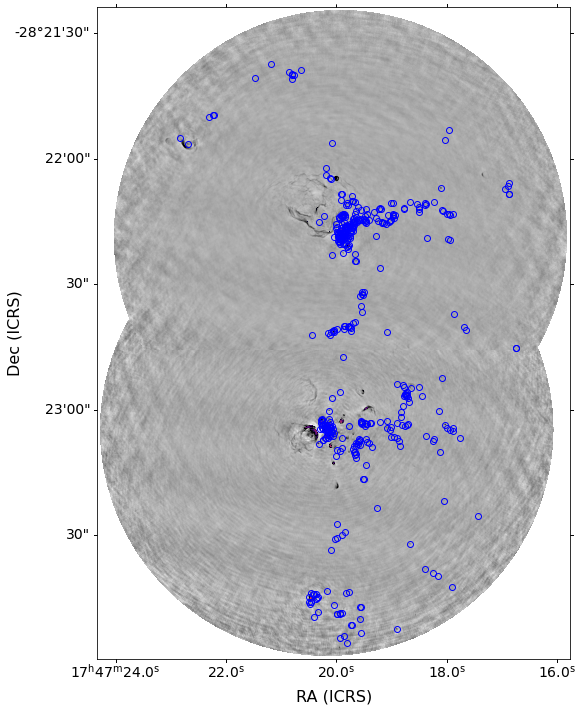

In [85]:
basefigure_full(Mcal,Ncal)

/scratch/local/10524092/ipykernel_31662/151120807.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


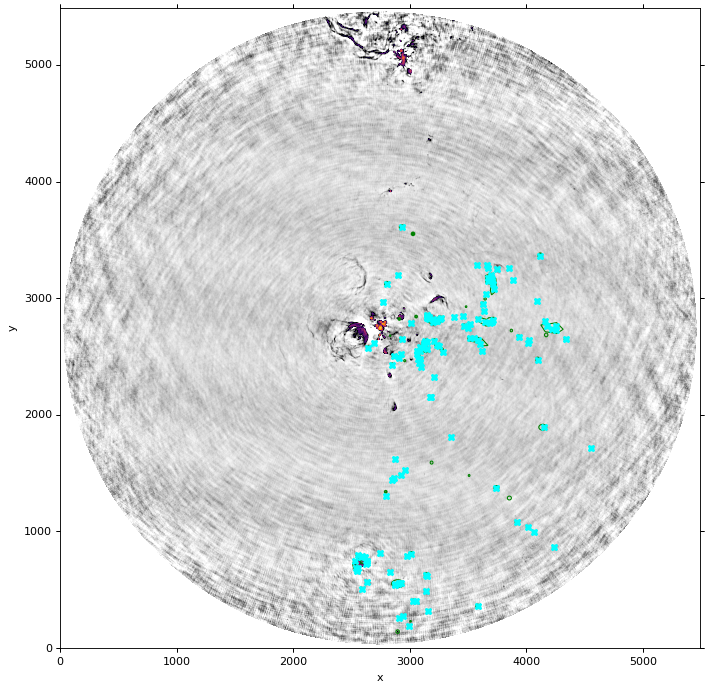

In [133]:
makefig(Mcal,catM_pixel,pixelM)

/scratch/local/10524092/ipykernel_31662/151120807.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_under((0,0,0,0))


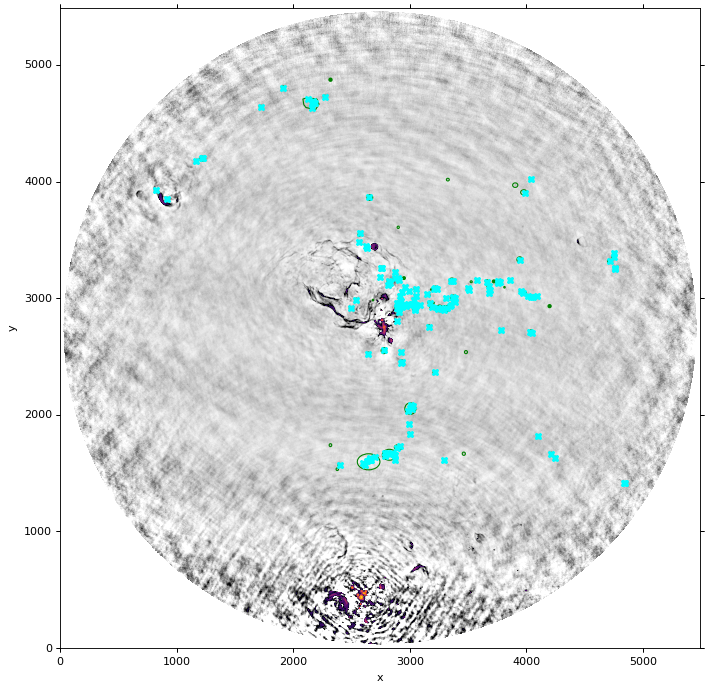

In [134]:
makefig(Ncal,catN_pixel,pixelN)

In [ ]:
makefig(Ncal,catN_pixel,pixelN,2300,3500,2200,3500,plotsources=True)

In [ ]:
makefig(Ncal,catN_pixel,pixelN,2300,3500,2200,3500,plotsources=False)

In [ ]:
makefig(Ncal,catN_pixel,pixelN,2600,3000,2500,3100,plotsources=True)

In [ ]:
makefig(Mcal,catM_pixel,pixelM,2400,3000,2400,3000,plotsources=False)

In [ ]:
makefig(Mcal,catM_pixel,pixelM,2400,3000,2400,3000)

In [ ]:
makefig(Mcal,catM_pixel,pixelM,2500,3100,100,700)

In [ ]:
makefig(Ncal,catN_pixel,pixelN,2500,3000,1500,1800,plotsources=True)

In [ ]:
makefig(Mcal,catM_pixel,pixelM,2700,3200,3800,4100)

In [ ]:
makefig(Mcal,catM_pixel,pixelM,2800,3500,2400,3000,plotsources=True)

In [ ]:
makefig(Ncal,catN_pixel,pixelN,2600,3000,2400,3000)

In [ ]:
makefig(Ncal,catN_pixel,pixelN,2800,3400,2800,3200)